In [1]:
import numpy as np
import os
import pandas as pd
import re
import requests
import kagglehub
import sys
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Machine Learning Project

by Andon Gorchov (@thunderman913)

In [2]:
path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

earnings_path = f"{path}\\stocks_latest\\earnings_latest.csv"
stock_prices_path = f"{path}\\stocks_latest\\stock_prices_latest.csv"

In [ ]:
# Function to get the price X days ago
def get_price_x_days_ago(df, days):
    return df['close'].shift(days)

def get_peak_price_and_days_ago(df):
    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

def process_ticker_data(df):
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)
        df[f'volume_{days}_days_ago'] = df.groupby('ticker')['volume'].shift(days)
    
    return df

In [4]:
# Adding earnings data to stock_data_tidy based on the nearest previous date
def add_earnings_data(stock_data, earnings):
    merged_df = pd.merge_asof(
        stock_data.sort_values(by='date'),
        earnings.sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='backward'
    )
    
    # Ensure non-trading days are adjusted properly
    merged_df = merged_df.sort_values(by=['ticker', 'date'])

    merged_df = pd.merge_asof(
        merged_df.sort_values(by='date'),
        earnings[['ticker', 'earnings_date']].sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='forward',
        suffixes=('', '_next'),
        allow_exact_matches=False
    )
    
    # Remove NA earnings dates
    merged_df = merged_df.drop(merged_df[(merged_df.earnings_date.isna()) | (merged_df.earnings_date_next.isna())].index)
    merged_df['days_till_report'] = (merged_df['earnings_date_next'] - merged_df['date']).dt.days
    merged_df['days_since_report'] = (merged_df['date'] - merged_df['earnings_date']).dt.days

    return merged_df

In [5]:
def getEarningsData():
    earnings_data_file = 'earnings_data_processed.pkl'

    if os.path.exists(earnings_data_file):
        return pd.read_pickle(earnings_data_file)

    earnings_data = pd.read_csv(earnings_path)

    earnings_data_tidy = earnings_data
    earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

    earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

    earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)
    earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

    earnings_data_tidy = earnings_data_tidy.rename(columns={'date': 'earnings_date'})

    earnings_data_tidy['release_time'] = earnings_data_tidy.groupby('ticker')['release_time'].ffill().bfill()

    earnings_data_tidy.to_pickle(earnings_data_file)

    return earnings_data_tidy

In [ ]:
def getTidiedStockData():
    stock_data_file = 'stock_data_processed.pkl'

    # Check if the file exists
    if os.path.exists(stock_data_file):
        return pd.read_pickle('stock_data_processed.pkl')

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    earnings_data_tidy = getEarningsData()

    stock_data_tidy = stock_data_tidy[(stock_data_tidy['date'] > (earnings_data_tidy['earnings_date'].min() - pd.Timedelta(days=100)))
                                    | (stock_data_tidy['date'] < earnings_data_tidy['earnings_date'].max() + pd.Timedelta(days=5))]

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]
    
    stock_data_tidy = add_earnings_data(stock_data_tidy, earnings_data_tidy)

    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])
    

    stock_data_tidy.to_pickle(stock_data_file)
    

    return stock_data_tidy

In [7]:
stock_data_tidy = getTidiedStockData()

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume'],
      dtype='object')
Index(['ticker', 'earnings_date', 'eps_est', 'eps', 'release_time'], dtype='object')


In [8]:
stock_data_tidy[['ticker','date', 'earnings_date', 'earnings_date_next', 'days_till_report', 'days_since_report']]

,ticker,date,earnings_date,earnings_date_next,days_till_report,days_since_report
11137135,C,2012-07-16,2012-07-16,2012-10-15,91,0
11138878,CSX,2012-07-17,2012-07-17,2012-10-16,91,0
11138900,FIS,2012-07-17,2012-07-17,2012-11-05,111,0
11139425,WYNN,2012-07-17,2012-07-17,2012-10-24,99,0
11140712,C,2012-07-17,2012-07-16,2012-10-15,90,1
...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,2020-09-10,2021-06-14,4,273
23692035,RFIL,2021-06-10,2021-03-11,2021-06-14,4,91
23693010,ADXS,2021-06-11,2020-09-10,2021-06-14,3,274
23693122,RFIL,2021-06-11,2021-03-11,2021-06-14,3,92


We remove data with more than 120 days on both next and previous report, since that is useless data for our case

In [10]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.days_till_report > 120) & (stock_data_tidy.days_since_report > 120)].index)

In [11]:
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

In [12]:
features = [
    'ticker_encoded', 'peak_price', 'peak_days_ago', 'price_1_days_ago', 'volume_1_days_ago',
    'price_2_days_ago', 'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
    'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago', 'volume_5_days_ago',
    'price_10_days_ago', 'volume_10_days_ago', 'price_15_days_ago', 'volume_15_days_ago',
    'price_30_days_ago', 'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
    'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps', 'days_till_report', 'days_since_report'
]

target = 'close'

In [36]:
stock_data_tidy_train = stock_data_tidy.sample(frac=0.005, random_state=42)

X = stock_data_tidy_train[features]
y = stock_data_tidy_train[target]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_main, X_final_test, y_main, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

forest_model = grid_search.best_estimator_
forest_model.fit(X_train, y_train)

train_score = forest_model.score(X_train, y_train)
print(f"Training Score: {train_score}")

y_pred = forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Score: 0.9992029033855365
Mean Squared Error: 116.58808512586604


In [ ]:
with open('forest_model.pkl', 'wb') as model_file:
    pickle.dump(forest_model, model_file)

In [24]:
with open('forest_model.pkl', 'rb') as model_file:
    forest_model = pickle.load(model_file)

Mean Squared Error for n_estimators=1: 411.3841126371389
Mean Squared Error for n_estimators=20: 114.82929450709904


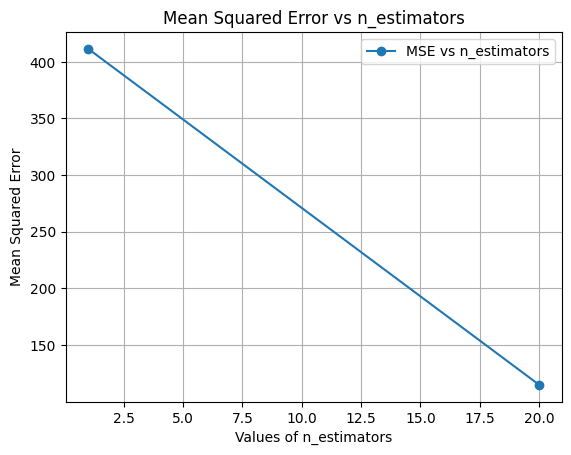

Mean Squared Error for max_depth=1: 9900.91076643849


KeyboardInterrupt: 

In [38]:
def evaluate_param(param_name, param_values):
    mse_values = []
    for value in param_values:
        model_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        model_params[param_name] = value
        model = RandomForestRegressor(**model_params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)
        print(f"Mean Squared Error for {param_name}={value}: {mse}")
    
    # Plot MSE for the parameter
    plt.figure()
    plt.plot(param_values, mse_values, marker='o', linestyle='-', label=f'MSE vs {param_name}')
    plt.xlabel(f'Values of {param_name}')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Mean Squared Error vs {param_name}')
    plt.grid(True)
    plt.legend()
    plt.show()

n_estimators_values = [1, 20, 50, 75, 100, 150, 200]
evaluate_param('n_estimators', n_estimators_values)

max_depth_values = [1, 5, 10, 20, 40]
evaluate_param('max_depth', max_depth_values)

min_samples_split_values = [2, 5, 10, 15, 20]
evaluate_param('min_samples_split', min_samples_split_values)

min_samples_leaf_values = [1, 2, 4, 8, 12, 20]
evaluate_param('min_samples_leaf', min_samples_leaf_values)

Mean Squared Error for n_estimators=1: 411.3841126371389
Mean Squared Error for n_estimators=20: 114.82929450709904
Mean Squared Error for n_estimators=50: 130.99741396458913
Mean Squared Error for n_estimators=75: 118.42973344359761
Mean Squared Error for n_estimators=100: 116.58808512586604
Mean Squared Error for n_estimators=150: 116.17154308228557
Mean Squared Error for n_estimators=200: 131.30237691542223


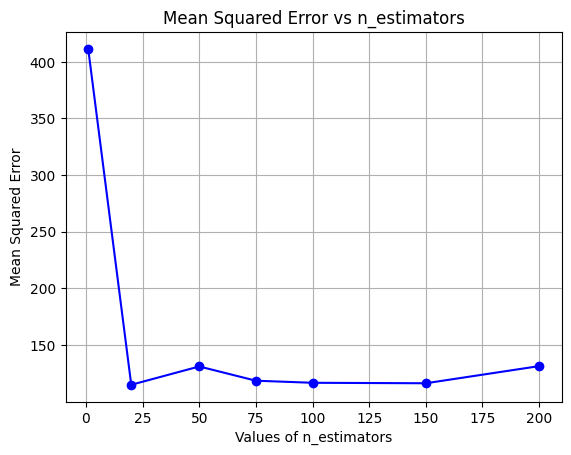

Mean Squared Error for max_depth=1: 9900.91076643849
Mean Squared Error for max_depth=5: 144.1112182986391
Mean Squared Error for max_depth=10: 116.58808512586604
Mean Squared Error for max_depth=20: 149.04001619438375
Mean Squared Error for max_depth=40: 130.20885055060313


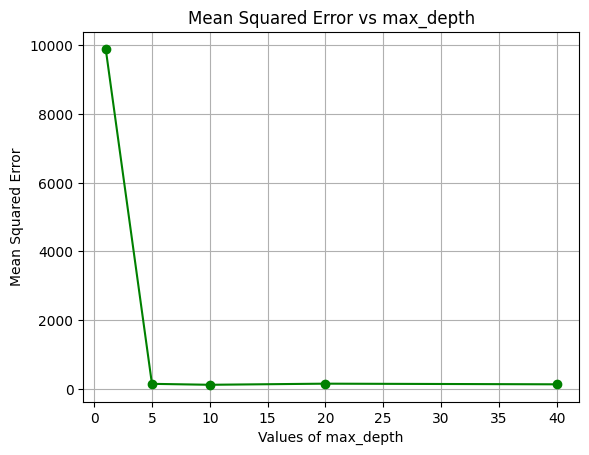

Mean Squared Error for min_samples_split=2: 116.58808512586604
Mean Squared Error for min_samples_split=5: 152.80975320298967
Mean Squared Error for min_samples_split=10: 388.0855964922002
Mean Squared Error for min_samples_split=15: 616.0358546495114
Mean Squared Error for min_samples_split=20: 650.6613133077987


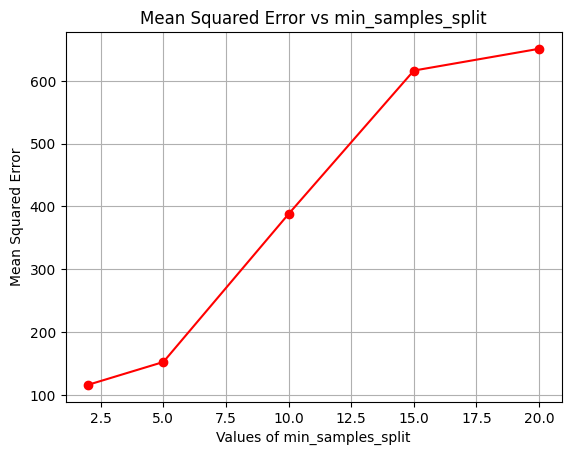

Mean Squared Error for min_samples_leaf=1: 116.58808512586604
Mean Squared Error for min_samples_leaf=2: 3995.423004600245
Mean Squared Error for min_samples_leaf=4: 1753343.3014423004
Mean Squared Error for min_samples_leaf=8: 4454898.202852478
Mean Squared Error for min_samples_leaf=12: 3070938.09245848
Mean Squared Error for min_samples_leaf=20: 2370635.1118802316


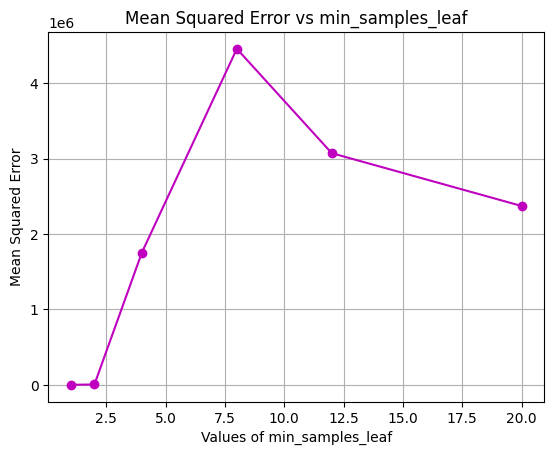

In [ ]:
mse_results = {}

n_estimators_values = [1, 20, 50, 75, 100, 150, 200]
mse_values_n_estimators = []
for n in n_estimators_values:
    model_params = best_params.copy()
    model_params['n_estimators'] = n
    model = RandomForestRegressor(**model_params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values_n_estimators.append(mse)
    print(f"Mean Squared Error for n_estimators={n}: {mse}")
mse_results['n_estimators'] = mse_values_n_estimators

plt.figure()
plt.plot(n_estimators_values, mse_values_n_estimators, marker='o', linestyle='-', color='b')
plt.xlabel('Values of n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs n_estimators')
plt.grid(True)
plt.show()

max_depth_values = [1, 5, 10, 20, 40]
mse_values_max_depth = []
for depth in max_depth_values:
    model_params = best_params.copy()
    model_params['max_depth'] = depth
    model = RandomForestRegressor(**model_params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values_max_depth.append(mse)
    print(f"Mean Squared Error for max_depth={depth}: {mse}")
mse_results['max_depth'] = mse_values_max_depth

plt.figure()
plt.plot(max_depth_values, mse_values_max_depth, marker='o', linestyle='-', color='g')
plt.xlabel('Values of max_depth')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs max_depth')
plt.grid(True)
plt.show()

min_samples_split_values = [2, 5, 10, 15, 20]
mse_values_min_samples_split = []
for split in min_samples_split_values:
    model_params = best_params.copy()
    model_params['min_samples_split'] = split
    model = RandomForestRegressor(**model_params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values_min_samples_split.append(mse)
    print(f"Mean Squared Error for min_samples_split={split}: {mse}")
mse_results['min_samples_split'] = mse_values_min_samples_split

plt.figure()
plt.plot(min_samples_split_values, mse_values_min_samples_split, marker='o', linestyle='-', color='r')
plt.xlabel('Values of min_samples_split')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs min_samples_split')
plt.grid(True)
plt.show()

min_samples_leaf_values = [1, 2, 4, 8, 12, 20]
mse_values_min_samples_leaf = []
for leaf in min_samples_leaf_values:
    model_params = best_params.copy()
    model_params['min_samples_leaf'] = leaf
    model = RandomForestRegressor(**model_params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values_min_samples_leaf.append(mse)
    print(f"Mean Squared Error for min_samples_leaf={leaf}: {mse}")
mse_results['min_samples_leaf'] = mse_values_min_samples_leaf

plt.figure()
plt.plot(min_samples_leaf_values, mse_values_min_samples_leaf, marker='o', linestyle='-', color='m')
plt.xlabel('Values of min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs min_samples_leaf')
plt.grid(True)
plt.show()


In [72]:
# TODO actually train the model :)

The best params seem to be {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}. Let's train the model with them

In [ ]:
train_score = forest_model.score(X_train, y_train)
print(f"Training Score: {train_score}")

train_score = forest_model.score(X_final_test, y_final_test)
print(f"Training Score: {train_score}")

Training Score: 0.9997892571422367


In [89]:
# TODO delete this or put in different notebook

aapl_data = {
    'ticker': ['AAPL'],
    'date': [pd.to_datetime('2024-05-10')],
    'peak_price': [183.38],  # Example value
    'peak_days_ago': [5],   # Example value
    'price_1_days_ago': [184.57],  # Example value
    'volume_1_days_ago': [48983000],  # Example value
    'price_2_days_ago': [182.74],  # Example value
    'volume_2_days_ago': [45057100],  # Example value
    'price_3_days_ago': [182.40],  # Example value
    'volume_3_days_ago': [77305800],  # Example value
    'price_4_days_ago': [181.71],  # Example value
    'volume_4_days_ago': [78569700],  # Example value
    'price_5_days_ago': [183.38],  # Example value
    'volume_5_days_ago': [163224100],  # Example value
    'price_10_days_ago': [160.89],  # Example value
    'volume_10_days_ago': [65934800],  # Example value
    'price_15_days_ago': [167.04],  # Example value
    'volume_15_days_ago': [49537800],  # Example value
    'price_30_days_ago': [169.24],  # Example value
    'volume_30_days_ago': [91070300],  # Example value
    'price_60_days_ago': [172.75],  # Example value
    'volume_60_days_ago': [60139500],  # Example value
    'price_90_days_ago': [183.86],  # Example value
    'volume_90_days_ago': [65454500],  # Example value
    'eps_est': [1.34],
    'eps': [1.4], 
    'days_till_report': [89],
    'days_since_report': [5],
    'ticker_encoded': [5]
}

# Convert to DataFrame
aapl_df = pd.DataFrame(aapl_data)

price_columns = [
    'peak_price', 'price_1_days_ago', 'price_2_days_ago', 'price_3_days_ago', 'price_4_days_ago',
    'price_5_days_ago', 'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago', 'eps_est', 'eps'
]

# Fit and transform the price-related columns
aapl_df[price_columns] = scaler.fit_transform(aapl_df[price_columns])


# Predict the closing price
aapl_features = aapl_df[features]
predicted_close = forest_model.predict(aapl_features)

print(f"Predicted closing price for AAPL on May 10, 2024: {[predicted_close]}")

Predicted closing price for AAPL on May 10, 2024: [array([91.94937996])]


C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [86]:
predicted_close[0]

np.float64(91.94937995906446)

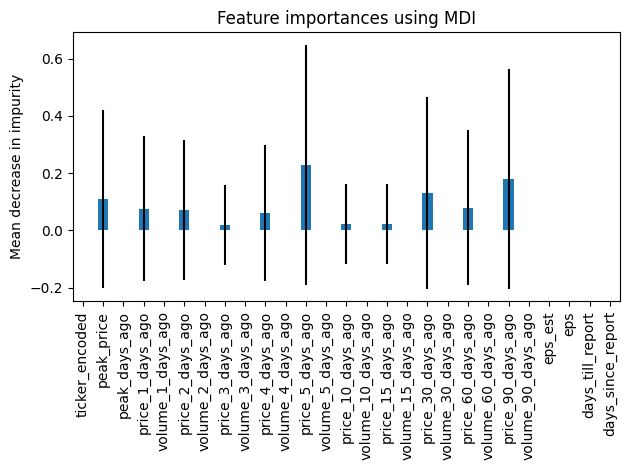

In [73]:
# TODO investigate the importances on the actual result
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

importances = forest_model.feature_importances_
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Linear Regression TODO check if all good and improve :)

Training Score: 0.9999340079779602
Mean Squared Error: 8333494.033319481


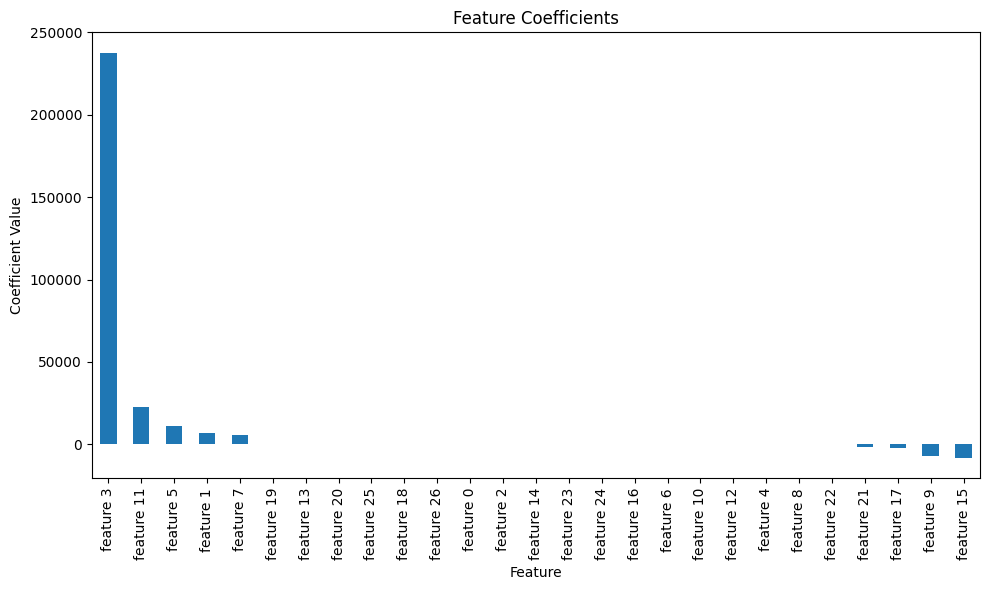

In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Score the model on the training data
train_score = linear_model.score(X_train, y_train)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred_scaled = linear_model.predict(X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred = y_pred_scaled * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

# Calculate and print the mean squared error
mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

# Linear regression does not provide feature importances in the same way as RandomForest
# Instead, we can look at the coefficients
coefficients = pd.Series(linear_model.coef_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Feature Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
train_score = linear_model.score(X_final_test, y_final_test)
print(f"Training Score: {train_score}")

Training Score: 0.9999007040346868


In [ ]:
X_final_test[1].__len__()
predicted_close = linear_model.predict(X_final_test[1306716].reshape(1,-1))
predicted_close

array([128.4002134])

In [ ]:
y_final_test

2104983      11.16
8425994       6.25
3930903      12.32
313824       86.38
7315858      60.65
             ...  
11549401     87.31
2077750     124.95
6411334       2.19
10796317      6.45
6562787     156.38
Name: close, Length: 1306720, dtype: float64

In [ ]:
forest_model.score(X_final_test, y_final_test)

0.9997892571422367

In [ ]:
X_final_test[1].__len__()
predicted_close = forest_model.predict(X_final_test[1306719].reshape(1,-1))
predicted_close

array([156.47])

In [ ]:
stock_data_tidy.close.mean()

np.float64(79.27421331343209)

Some error calculations

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MSE (Lower better)
mse = mean_squared_error(y_test, y_pred)
print("MSE of testing set:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE of testing set:", mae)

# Calculate RMSE (Lower better)
rmse = np.sqrt(mse)
print("RMSE of testing set:", rmse)

MSE of testing set: 8333494.033319481
MAE of testing set: 189.62171576523662
RMSE of testing set: 2886.7791798680205


Getting the perfect model, but we need more data

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_distributions,
                                   n_iter=5, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train[:10000], y_train[:10000])
forest_model = random_search.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

In [ ]:
forest_model

RandomForestRegressor(max_depth=30, n_estimators=500, random_state=42)

In [ ]:
forest_model.score(X_train, y_train)

0.9923147943983335